In [2]:
# Vision-Language Encoder Comparison
# 探索不同体量的vision encoder和language model的cosine similarity

# ========== Installation ==========
!pip install torch torchvision transformers timm datasets pillow numpy matplotlib seaborn
!pip install accelerate

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import (
    GPT2LMHeadModel, GPT2Tokenizer,
    AutoTokenizer, AutoModelForCausalLM,
    CLIPProcessor, CLIPModel
)
import timm
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import requests
from io import BytesIO
import warnings
warnings.filterwarnings('ignore')

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# 不同模型

In [5]:
# Vision Encoders Setup
class VisionEncoderWrapper(nn.Module):
    """Wrapper for vision encoders to extract features"""
    def __init__(self, model_name):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=True, num_classes=0)
        self.model.eval()

    def forward(self, x):
        return self.model(x)

    @property
    def feature_dim(self):
        return self.model.num_features

# Initialize vision encoders
vision_models = {
    'vit_small': VisionEncoderWrapper('vit_small_patch16_224'),
    'vit_base': VisionEncoderWrapper('vit_base_patch16_224'),
    'vit_large': VisionEncoderWrapper('vit_large_patch16_224')
}

for name, model in vision_models.items():
    model.to(device)
    print(f"{name}: feature_dim = {model.feature_dim}")
'''
# Language Models Setup， 无position版本
class LanguageModelWrapper:
    """Wrapper for language models to extract input embeddings"""
    def __init__(self, model_name):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForCausalLM.from_pretrained(model_name)
        self.model.eval()

        # Add pad token if not exists
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

    def get_input_embeddings(self, texts):
        tokens = self.tokenizer(texts, return_tensors='pt', padding=True, truncation=True)
        with torch.no_grad():
            # Get input embeddings from embedding layer
            embeddings = self.model.get_input_embeddings()(tokens['input_ids'])
        return embeddings.mean(dim=1)  # Average over sequence length

    @property
    def embedding_dim(self):
        return self.model.config.hidden_size
'''
# Language Models Setup， 含position版本
class LanguageModelWrapper:
    """Wrapper for language models to extract input embeddings with position embeddings"""
    def __init__(self, model_name):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForCausalLM.from_pretrained(model_name)
        self.model.eval()

        # Add pad token if not exists
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

    def get_input_embeddings(self, texts):
        """Get complete input embeddings including position embeddings"""
        if isinstance(texts, str):
            texts = [texts]

        tokens = self.tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=77)
        tokens = {k: v.to(device) for k, v in tokens.items()}

        with torch.no_grad():
            # Get complete input embeddings (token + position + other embeddings)
            if hasattr(self.model, 'transformer'):  # GPT-2 style models
                # Token embeddings
                token_embeds = self.model.transformer.wte(tokens['input_ids'])

                # Position embeddings
                seq_len = tokens['input_ids'].size(1)
                position_ids = torch.arange(seq_len, dtype=torch.long, device=device)
                position_ids = position_ids.unsqueeze(0).expand_as(tokens['input_ids'])
                pos_embeds = self.model.transformer.wpe(position_ids)

                # Combine embeddings (this is what the model actually sees as input)
                full_embeddings = token_embeds + pos_embeds

            elif hasattr(self.model, 'model') and hasattr(self.model.model, 'embed_tokens'):
                # Other architectures (LLaMA, etc.)
                token_embeds = self.model.model.embed_tokens(tokens['input_ids'])

                # Add position embeddings if they exist
                if hasattr(self.model.model, 'embed_positions'):
                    pos_embeds = self.model.model.embed_positions(tokens['input_ids'])
                    full_embeddings = token_embeds + pos_embeds
                else:
                    # Some models use rotary embeddings or other position encoding
                    full_embeddings = token_embeds

            else:
                # Fallback: just token embeddings
                full_embeddings = self.model.get_input_embeddings()(tokens['input_ids'])
                print(f"Warning: Could not add position embeddings for {self.model.config.model_type}")

        # Average over sequence length, considering attention mask
        if 'attention_mask' in tokens:
            mask = tokens['attention_mask'].unsqueeze(-1).float()
            masked_embeddings = full_embeddings * mask
            lengths = mask.sum(dim=1)
            return (masked_embeddings.sum(dim=1) / lengths.clamp(min=1))
        else:
            return full_embeddings.mean(dim=1)

    @property
    def embedding_dim(self):
        return self.model.config.hidden_size

# Initialize language models
language_models = {
    'gpt2': LanguageModelWrapper('gpt2'),
    'gpt2-medium': LanguageModelWrapper('gpt2-medium'),
    'gpt2-large': LanguageModelWrapper('gpt2-large')
}

for name, model in language_models.items():
    model.model.to(device)
    print(f"{name}: embedding_dim = {model.embedding_dim}")

# Projection Layers
class ProjectionLayer(nn.Module):
    """Linear projection from vision features to language embedding space"""
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.projection = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.projection(x)

# Create projection layers for each vision-language pair
projection_layers = {}
for v_name, v_model in vision_models.items():
    for l_name, l_model in language_models.items():
        proj_name = f"{v_name}_to_{l_name}"
        projection_layers[proj_name] = ProjectionLayer(
            v_model.feature_dim,
            l_model.embedding_dim
        ).to(device)
        print(f"Created projection: {proj_name} ({v_model.feature_dim} -> {l_model.embedding_dim})")

vit_small: feature_dim = 384
vit_base: feature_dim = 768
vit_large: feature_dim = 1024
gpt2: embedding_dim = 768
gpt2-medium: embedding_dim = 1024
gpt2-large: embedding_dim = 1280
Created projection: vit_small_to_gpt2 (384 -> 768)
Created projection: vit_small_to_gpt2-medium (384 -> 1024)
Created projection: vit_small_to_gpt2-large (384 -> 1280)
Created projection: vit_base_to_gpt2 (768 -> 768)
Created projection: vit_base_to_gpt2-medium (768 -> 1024)
Created projection: vit_base_to_gpt2-large (768 -> 1280)
Created projection: vit_large_to_gpt2 (1024 -> 768)
Created projection: vit_large_to_gpt2-medium (1024 -> 1024)
Created projection: vit_large_to_gpt2-large (1024 -> 1280)


In [10]:
'''
# Dataset Preparation
def load_sample_data(num_samples=30): #test,后续可改100
    # Using COCO captions dataset
    #  dataset = load_dataset("HuggingFaceM4/COCO", split="validation")
    dataset = load_dataset("HuggingFaceM4/flickr30k", split="train")

    # Sample data
    samples = []
    for i, item in enumerate(dataset):
        if i >= num_samples:
            break

        image = item['image']
        caption = item['caption'][0] if isinstance(item['caption'], list) else item['caption']
        samples.append((image, caption))

    return samples

# Load sample data
print("Loading sample data...")
sample_data = load_sample_data(30)
print(f"Loaded {len(sample_data)} image-caption pairs")
'''

'\n# Dataset Preparation\ndef load_sample_data(num_samples=30): #test,后续可改100\n    # Using COCO captions dataset\n    #  dataset = load_dataset("HuggingFaceM4/COCO", split="validation")\n    dataset = load_dataset("HuggingFaceM4/flickr30k", split="train")\n    \n    # Sample data\n    samples = []\n    for i, item in enumerate(dataset):\n        if i >= num_samples:\n            break\n        \n        image = item[\'image\']\n        caption = item[\'caption\'][0] if isinstance(item[\'caption\'], list) else item[\'caption\']\n        samples.append((image, caption))\n    \n    return samples\n\n# Load sample data\nprint("Loading sample data...")\nsample_data = load_sample_data(30)\nprint(f"Loaded {len(sample_data)} image-caption pairs")\n'

In [7]:
#把数据集存到google drive cache

import os
from google.colab import drive # 导入 Google Drive 模块

print("正在挂载 Google Drive...")
drive.mount('/content/drive')
print("Google Drive 挂载完成。")

DRIVE_CACHE_DIR = '/content/drive/MyDrive/huggingface_datasets_cache'

os.makedirs(DRIVE_CACHE_DIR, exist_ok=True)
print(f"确保数据集缓存目录存在：{DRIVE_CACHE_DIR}")



正在挂载 Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive 挂载完成。
确保数据集缓存目录存在：/content/drive/MyDrive/huggingface_datasets_cache


In [22]:

# Dataset Preparation
def load_sample_data(num_samples=60): #test,后续可增加
    print(f"正在尝试从 '{DRIVE_CACHE_DIR}' 加载或下载数据集...")
    # 使用 COCO captions dataset
    dataset = load_dataset(
        "nlphuji/flickr30k",
        split="test",
        cache_dir=DRIVE_CACHE_DIR # 将数据集缓存到 Google Drive
    )

    # Sample data
    samples = []
    for i, item in enumerate(dataset):
        if i >= num_samples:
            break

        image = item['image']
        caption = item['caption'][0] if isinstance(item['caption'], list) else item['caption']
        samples.append((image, caption))

    return samples

# Load sample data
print("加载示例数据中...")
sample_data = load_sample_data(60)
print(f"已加载 {len(sample_data)} 张图片-描述对")


加载示例数据中...
正在尝试从 '/content/drive/MyDrive/huggingface_datasets_cache' 加载或下载数据集...
已加载 60 张图片-描述对


In [9]:
# Image Preprocessing
def preprocess_image(image, size=224):
    """Preprocess image for vision models"""
    if isinstance(image, str):
        # If URL, download image
        response = requests.get(image)
        image = Image.open(BytesIO(response.content))

    # Convert to RGB if needed
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Resize and normalize
    image = image.resize((size, size))

    # Convert to tensor and normalize (ImageNet stats)
    transform = timm.data.create_transform(
        input_size=size,
        is_training=False,
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )

    return transform(image).unsqueeze(0)

# Training Loop
def train_projection_layer(vision_model, language_model, projection_layer,
                          data_samples, epochs=10, lr=1e-3):
    #Train projection layer with contrastive learning
    optimizer = torch.optim.Adam(projection_layer.parameters(), lr=lr)
    projection_layer.train()

    for epoch in range(epochs):
        total_loss = 0
        for i, (image, caption) in enumerate(data_samples):
            try:
                # Process image
                img_tensor = preprocess_image(image).to(device)

                # Get vision features
                with torch.no_grad():
                    vision_features = vision_model(img_tensor)

                # Project vision features
                projected_vision = projection_layer(vision_features)

                # Get language input embeddings
                with torch.no_grad():
                    lang_embeddings = language_model.get_input_embeddings([caption]).to(device)

                # Contrastive loss (simplified)
                # Positive: same image-caption pair should be similar
                pos_sim = F.cosine_similarity(projected_vision, lang_embeddings, dim=1)

                # Negative: different captions should be dissimilar
                if i > 0:
                    prev_caption = data_samples[i-1][1]
                    neg_embeddings = language_model.get_input_embeddings([prev_caption]).to(device)
                    neg_sim = F.cosine_similarity(projected_vision, neg_embeddings, dim=1)

                    # Contrastive loss
                    loss = torch.clamp(0.2 - pos_sim + neg_sim, min=0.0).mean()
                else:
                    loss = (1.0 - pos_sim).mean()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            except Exception as e:
                print(f"Error processing sample {i}: {e}")
                continue

        avg_loss = total_loss / len(data_samples)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    projection_layer.eval()


In [23]:
# Training All Projection Layers
print("Starting training...")
for proj_name, proj_layer in projection_layers.items():
    v_name, l_name = proj_name.split('_to_')
    print(f"\nTraining {proj_name}...")

    train_projection_layer(
        vision_models[v_name],
        language_models[l_name],
        proj_layer,
        sample_data[:30],  # Use subset for faster training
        epochs=5
    )


Starting training...

Training vit_small_to_gpt2...
Epoch 1/5, Loss: 0.0138
Epoch 2/5, Loss: 0.0200
Epoch 3/5, Loss: 0.0082
Epoch 4/5, Loss: 0.0072
Epoch 5/5, Loss: 0.0075

Training vit_small_to_gpt2-medium...
Epoch 1/5, Loss: 0.0024
Epoch 2/5, Loss: 0.0227
Epoch 3/5, Loss: 0.0025
Epoch 4/5, Loss: 0.0022
Epoch 5/5, Loss: 0.0021

Training vit_small_to_gpt2-large...
Epoch 1/5, Loss: 0.0013
Epoch 2/5, Loss: 0.0176
Epoch 3/5, Loss: 0.0087
Epoch 4/5, Loss: 0.0020
Epoch 5/5, Loss: 0.0041

Training vit_base_to_gpt2...
Epoch 1/5, Loss: 0.0081
Epoch 2/5, Loss: 0.0351
Epoch 3/5, Loss: 0.0127
Epoch 4/5, Loss: 0.0089
Epoch 5/5, Loss: 0.0078

Training vit_base_to_gpt2-medium...
Epoch 1/5, Loss: 0.0024
Epoch 2/5, Loss: 0.0268
Epoch 3/5, Loss: 0.0018
Epoch 4/5, Loss: 0.0015
Epoch 5/5, Loss: 0.0048

Training vit_base_to_gpt2-large...
Epoch 1/5, Loss: 0.0046
Epoch 2/5, Loss: 0.0260
Epoch 3/5, Loss: 0.0028
Epoch 4/5, Loss: 0.0070
Epoch 5/5, Loss: 0.0047

Training vit_large_to_gpt2...
Epoch 1/5, Loss: 0.


Evaluating all combinations...
vit_small_to_gpt2: Mean similarity = 0.0857 ± 0.1624
vit_small_to_gpt2-medium: Mean similarity = 0.1987 ± 0.1340
vit_small_to_gpt2-large: Mean similarity = 0.2713 ± 0.1207
vit_base_to_gpt2: Mean similarity = 0.1439 ± 0.2112
vit_base_to_gpt2-medium: Mean similarity = 0.3522 ± 0.2031
vit_base_to_gpt2-large: Mean similarity = 0.2614 ± 0.1807
vit_large_to_gpt2: Mean similarity = 0.1825 ± 0.1826
vit_large_to_gpt2-medium: Mean similarity = 0.3867 ± 0.1556
vit_large_to_gpt2-large: Mean similarity = 0.4467 ± 0.1308


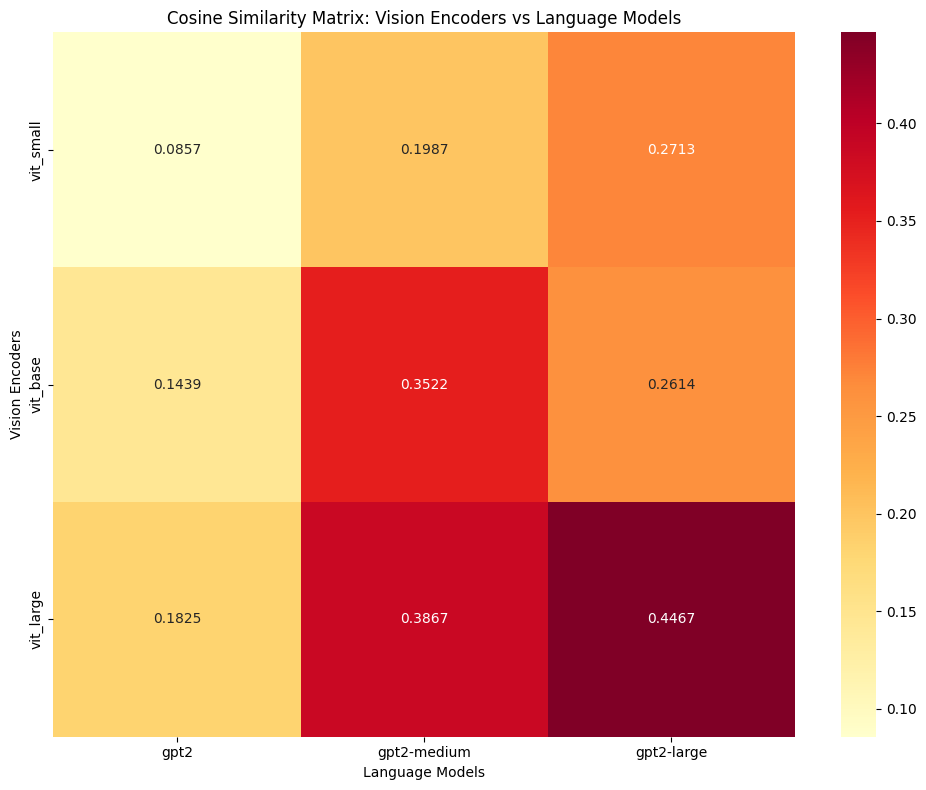


ANALYSIS RESULTS
Best combination: vit_large_to_gpt2-large
  Mean similarity: 0.4467
  Std: 0.1308

Worst combination: vit_small_to_gpt2
  Mean similarity: 0.0857
  Std: 0.1624

Trends:
vit_small: gpt2-large(0.271) > gpt2-medium(0.199) > gpt2(0.086)
vit_base: gpt2-medium(0.352) > gpt2-large(0.261) > gpt2(0.144)
vit_large: gpt2-large(0.447) > gpt2-medium(0.387) > gpt2(0.183)

Experiment completed!
Total combinations tested: 9
Average similarity across all combinations: 0.2588


In [25]:
# Evaluation
def evaluate_similarity(vision_model, language_model, projection_layer, test_samples):
    """Evaluate cosine similarity between projected vision and language embeddings"""
    similarities = []

    with torch.no_grad():
        for image, caption in test_samples:
            try:
                # Process image
                img_tensor = preprocess_image(image).to(device)

                # Get vision features and project
                vision_features = vision_model(img_tensor)
                projected_vision = projection_layer(vision_features)

                # Get language embeddings
                lang_embeddings = language_model.get_input_embeddings([caption]).to(device)

                # Calculate similarity
                similarity = F.cosine_similarity(projected_vision, lang_embeddings, dim=1)
                similarities.append(similarity.item())

            except Exception as e:
                print(f"Error in evaluation: {e}")
                continue



    return similarities

# Results Collection
print("\nEvaluating all combinations...")
results = {}

for proj_name, proj_layer in projection_layers.items():
    v_name, l_name = proj_name.split('_to_')

    similarities = evaluate_similarity(
        vision_models[v_name],
        language_models[l_name],
        proj_layer,
        sample_data[30:60]  # Use different samples for evaluation
    )

    results[proj_name] = {
        'similarities': similarities,
        'mean': np.mean(similarities),
        'std': np.std(similarities)
    }

    print(f"{proj_name}: Mean similarity = {results[proj_name]['mean']:.4f} ± {results[proj_name]['std']:.4f}")

# Visualization
# Create similarity matrix
vision_names = list(vision_models.keys())
language_names = list(language_models.keys())

similarity_matrix = np.zeros((len(vision_names), len(language_names)))

for i, v_name in enumerate(vision_names):
    for j, l_name in enumerate(language_names):
        proj_name = f"{v_name}_to_{l_name}"
        similarity_matrix[i, j] = results[proj_name]['mean']

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix,
            xticklabels=language_names,
            yticklabels=vision_names,
            annot=True,
            fmt='.4f',
            cmap='YlOrRd')
plt.title('Cosine Similarity Matrix: Vision Encoders vs Language Models')
plt.xlabel('Language Models')
plt.ylabel('Vision Encoders')
plt.tight_layout()
plt.show()

# ========== Analysis ==========
print("\n" + "="*50)
print("ANALYSIS RESULTS")
print("="*50)

# Find best and worst combinations
best_combo = max(results.keys(), key=lambda x: results[x]['mean'])
worst_combo = min(results.keys(), key=lambda x: results[x]['mean'])

print(f"Best combination: {best_combo}")
print(f"  Mean similarity: {results[best_combo]['mean']:.4f}")
print(f"  Std: {results[best_combo]['std']:.4f}")

print(f"\nWorst combination: {worst_combo}")
print(f"  Mean similarity: {results[worst_combo]['mean']:.4f}")
print(f"  Std: {results[worst_combo]['std']:.4f}")

# Analyze trends
print(f"\nTrends:")
for v_name in vision_names:
    v_results = [(l_name, results[f"{v_name}_to_{l_name}"]['mean'])
                 for l_name in language_names]
    v_results.sort(key=lambda x: x[1], reverse=True)
    print(f"{v_name}: {' > '.join([f'{l}({s:.3f})' for l, s in v_results])}")

print(f"\nExperiment completed!")
print(f"Total combinations tested: {len(results)}")
print(f"Average similarity across all combinations: {np.mean([r['mean'] for r in results.values()]):.4f}")
